# Computing reflectance as least squares fit

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

We will use the dark corrected (dark reference subtracted) DN values as the base data:

In [2]:
dn_ds = xr.open_dataset('data/dn_dc.nc', chunks={'filename': 1})
dn_ds

<xarray.Dataset>
Dimensions:            (band: 128, filename: 23, x: 520, y: 696)
Coordinates:
  * filename           (filename) object '_I50_L0-511_3-10-2018_10.59.48_White' ... '_I50_L0-511_3-10-2018_14.0.19_Dark'
  * band               (band) int64 1 2 3 4 5 6 7 ... 123 124 125 126 127 128
  * y                  (y) float64 0.5 1.5 2.5 3.5 ... 692.5 693.5 694.5 695.5
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 516.5 517.5 518.5 519.5
Data variables:
    wavelength         (band) float64 dask.array<shape=(128,), chunksize=(128,)>
    distance           (filename) object dask.array<shape=(23,), chunksize=(1,)>
    tile               (filename) object dask.array<shape=(23,), chunksize=(1,)>
    dark_corrected_dn  (filename, band, y, x) uint16 dask.array<shape=(23, 128, 696, 520), chunksize=(1, 128, 696, 520)>

The white reference is the data from PTFE plaque level with the other tiles:

In [3]:
ref_file = '_I50_L0-511_3-10-2018_13.50.8_PTFE_'
dn_ds['reference_dn'] = dn_ds.sel(filename=ref_file)['dark_corrected_dn']

In [4]:
def color_pts(len_x, len_y):
    cr, cg = np.meshgrid(np.linspace(0, 1, len_x), np.linspace(0, 1, len_y))
    return np.stack([np.zeros(len_x*len_y), cr.ravel(), cg.ravel()], axis=1)


We select a set of pixels and plot the values of the sample against the reference at a given wavelength. The yellow dot is the center of mass of the points (mean of the sample points / mean of the reference points), and the line is the least squares fit of a line through the origin. Plots with "None" as their label are PTFE references at different heights and the dark reference.

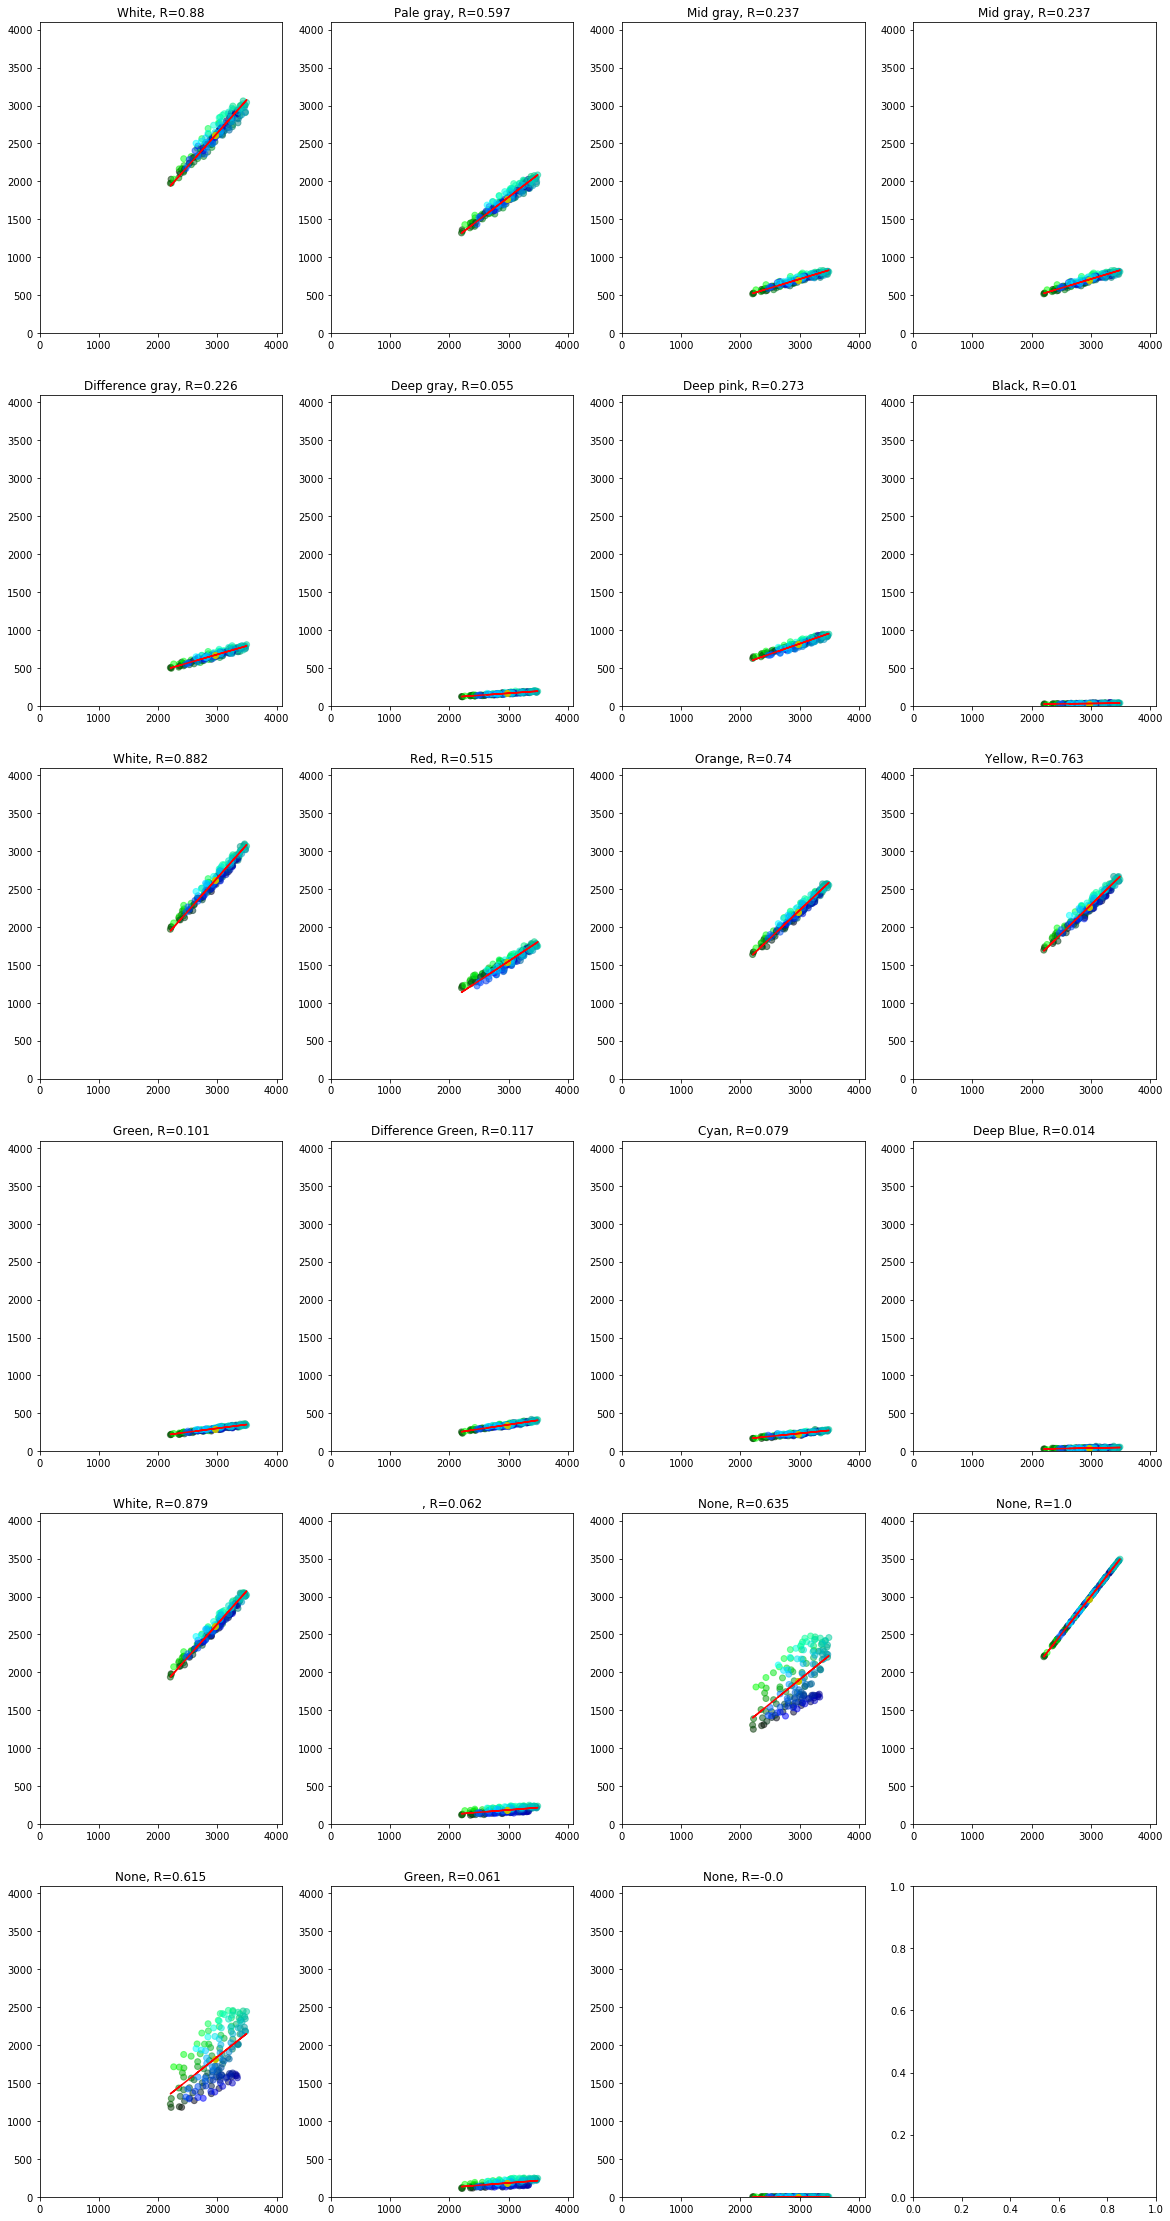

In [5]:
roi = {
    'x': slice(0, -1, 50),
    'y': slice(0, -1, 50),
}
boi = {'band': 50}

fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(20,40))
axs = axs.ravel()
x = dn_ds.isel(**roi, **boi)['reference_dn'].data.ravel()
c = color_pts(dn_ds.isel(**roi).x.size, dn_ds.isel(**roi).y.size)
for k in range(dn_ds.filename.size):
    y = dn_ds.isel(filename=k, **roi, **boi)['dark_corrected_dn'].data.ravel()
    R = np.float64(np.linalg.lstsq(x.reshape(x.size, 1), y.reshape(y.size, 1), rcond=None)[0])
    axs[k].scatter(x, y, c=c, alpha=0.5)
    axs[k].scatter(np.mean(x), np.mean(y), color='y')
    axs[k].plot(x, R * x, color='r')
    axs[k].set_title(f"{dn_ds.isel(filename=k)['tile'].values}, R={np.round(R, decimals=3)}")
    axs[k].set_xlim((0, 4096))
    axs[k].set_ylim((0, 4096))

In [24]:
#plt.style.available
#plt.style.use('dark_background')
plt.style.use('fast')

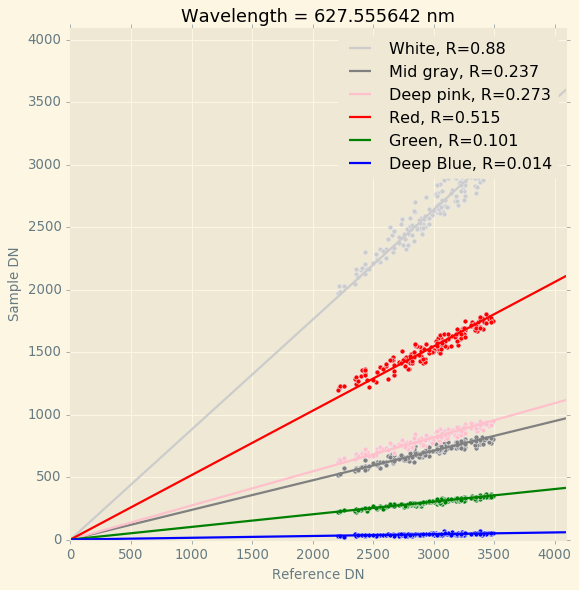

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
x = dn_ds.isel(**roi, **boi)['reference_dn'].data.ravel()
c = ['0.80', 'grey', 'pink', 'red', 'green', 'blue']
lg = []
for k, f in enumerate(dn_ds.filename[slice(0, -7, 3)]):
    y = dn_ds.sel(filename=f).isel(**roi, **boi)['dark_corrected_dn'].data.ravel()
    R = np.float64(np.linalg.lstsq(x.reshape(x.size, 1), y.reshape(y.size, 1), rcond=None)[0])
    Rmean = np.mean(x / y)
    ax.scatter(x, y, c=c[k])
    ax.plot(np.arange(4096), R * np.arange(4096), c=c[k])
    #ax.scatter(np.mean(x), np.mean(y), color='k')
    lg.append(f"{dn_ds.sel(filename=f)['tile'].values}, R={np.round(R, decimals=3)}")
ax.set_xlim((0, 4096))
ax.set_ylim((0, 4096))
ax.legend(lg)
ax.set_title(f'Wavelength = {float(dn_ds.wavelength.isel(**boi))} nm')
ax.set_ylabel('Sample DN')
ax.set_xlabel('Reference DN')
plt.savefig('various_tiles.png')
plt.show()

# Allowing an intercept
Next we compute a line fit of the same data, now allowing an intercept. Here we will also include the PTFE reflectance factor as correction for the reference.

In [26]:
import holoviews as hv
hv.extension('bokeh', 'matplotlib')

ModuleNotFoundError: No module named 'holoviews'

In [27]:
from scipy.stats import linregress
from radiometry import PTFE_reflectance_factor_45_0

In [28]:
def R_plot(filename, wavelength):
    ds = dn_ds.isel(**roi).swap_dims({'band': 'wavelength'})
    rfac = PTFE_reflectance_factor_45_0().interp_like(ds.wavelength, kwargs={'fill_value': 'extrapolate'})
    x = (ds.sel(wavelength=wavelength)['reference_dn'] * rfac.sel(wavelength=wavelength)).data.ravel()
    y = ds.sel(filename=filename, wavelength=wavelength)['dark_corrected_dn'].data.ravel()
    R, resid, _, _ = np.linalg.lstsq(x.reshape(x.size, 1), y.reshape(y.size, 1), rcond=None)
    fit = linregress(x, y)
    scatter = hv.Scatter(np.stack([x,y], axis=-1))
    line = hv.Curve([[0, 0],[4096, R * 4096]],  label=f'R={np.round(float(R), decimals=2)}, res/N_px={int(resid)/len(x)}').options({'Curve':{'color':'black'}})
    fit_line = hv.Curve([[0, fit[1]],[4096, fit[0] * 4096 + fit[1]]],  label=f'slope={np.round(fit[0], decimals=2)}, intercept/max(DN)={np.round(fit[1]/y.max(), decimals=2)}').options({'Curve':{'color':'red'}})
    return scatter * line * fit_line

In [29]:
%%output size=150
dmap = hv.DynamicMap(
    R_plot, kdims=['filename', 'wavelength'],
).redim.values(
    filename=dn_ds.filename.data,
    wavelength=dn_ds.wavelength.data
).redim(
    x=hv.Dimension('ref', label='Reference DN', range=(0, 4096)),
    y=hv.Dimension('dn', label='Sample DN', range=(0, 4096))
)
dmap

UsageError: Cell magic `%%output` not found.


In [30]:
from radiometry import linear_regression

def compute_Rs(ds):
    signal = ds['dark_corrected_dn']
    ref = ds['reference_dn']
    ds['R_from_mean_dn'] = signal.groupby('band').mean() / ref.groupby('band').mean()
    ds['mean_R'] = (signal / ref).groupby('band').mean()
    ds = ds.merge(linear_regression(ds, 'reference_dn', 'dark_corrected_dn', 'band'))
    return ds

roi_fits_ds = dn_ds.isel(**roi).groupby('filename').apply(compute_Rs)

/home/maaleske/miniconda3/envs/colortiles/lib/python3.7/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/home/maaleske/miniconda3/envs/colortiles/lib/python3.7/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/home/maaleske/miniconda3/envs/colortiles/lib/python3.7/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/home/maaleske/miniconda3/envs/colortiles/l

In [10]:
#roi_fits_ds = roi_fits_ds.set_coords('wavelength').swap_dims({'band': 'wavelength'})
roi_fits_ds

<xarray.Dataset>
Dimensions:            (band: 128, filename: 23, x: 11, y: 14)
Coordinates:
  * band               (band) int32 1 2 3 4 5 6 7 ... 123 124 125 126 127 128
  * y                  (y) float64 0.5 50.5 100.5 150.5 ... 550.5 600.5 650.5
  * x                  (x) float64 0.5 50.5 100.5 150.5 ... 400.5 450.5 500.5
  * filename           (filename) object '_I50_L0-511_3-10-2018_10.59.48_White' ... '_I50_L0-511_3-10-2018_14.0.19_Dark'
Data variables:
    wavelength         (filename, band) float64 dask.array<shape=(23, 128), chunksize=(1, 1)>
    distance           (filename, band) object dask.array<shape=(23, 128), chunksize=(1, 1)>
    tile               (filename, band) object dask.array<shape=(23, 128), chunksize=(1, 1)>
    dark_corrected_dn  (filename, band, y, x) uint16 dask.array<shape=(23, 128, 14, 11), chunksize=(1, 1, 14, 11)>
    reference_dn       (filename, band, y, x) uint16 dask.array<shape=(23, 128, 14, 11), chunksize=(1, 1, 14, 11)>
    R_from_mean_dn     (fi

In [11]:
def fit_plot(filename):
    ds = roi_fits_ds.sel(filename=filename).set_coords('wavelength').swap_dims({'band':'wavelength'})
    slope = hv.Curve(ds, kdims=['wavelength'], vdims='slope', label='slope of fit')
    intercept = hv.Curve(ds, kdims=['wavelength'], vdims='intercept')
    R1 = hv.Curve(ds, kdims=['wavelength'], vdims='R_from_mean_dn', label='Ratio of means')
    R2 = hv.Curve(ds, kdims=['wavelength'], vdims='mean_R', label='Mean of ratios')
    return slope * R1 * R2 + intercept

In [12]:
hv.DynamicMap(
    fit_plot, kdims=['filename']
).redim.values(
    filename=dn_ds.filename.data,
).redim.range(
    slope=(0,1),
    intercept=(-100, 1500),
)

:DynamicMap   [filename]
   :Layout
      .Overlay.I :Overlay
         .Curve.Slope_of_fit                  :Curve   [wavelength]   (slope)
         .Curve.Reflectance_of_mean_radiances :Curve   [wavelength]   (R_from_mean_dn)
         .Curve.Mean_reflectance              :Curve   [wavelength]   (mean_R)
      .Curve.I   :Curve   [wavelength]   (intercept)

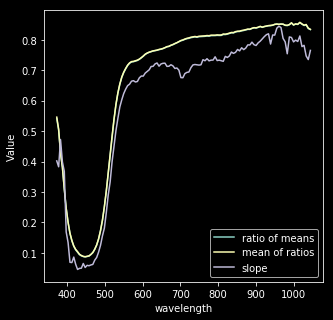

In [36]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
for v in ['R_from_mean_dn', 'mean_R', '', 'slope']:
    roi_fits_ds.isel(filename=11).swap_dims({'band':'wavelength'})[v].plot.line(x='wavelength', ax=ax)
ax.legend(['ratio of means', 'mean of ratios', 'slope'])
ax.set_title('')
ax.set_ylabel('Value')
plt.savefig('R_comparison.png')
plt.show()

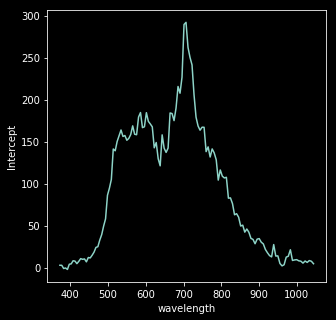

In [38]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
for v in ['intercept']:
    roi_fits_ds.isel(filename=11).swap_dims({'band':'wavelength'})[v].plot.line(x='wavelength', ax=ax)
ax.set_title('')
ax.set_ylabel('Intercept')
plt.savefig('intercept.png')
plt.show()